In [1]:
import scipy.io
import numpy as np
from IPython.display import Image
from PIL import Image 
import sys 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.extmath import randomized_svd
import matplotlib.image as mpimg

## ImgProcessing


### HandWritten Image Processing

* Load the images. 

The images are in .png format, so they can simply been loaded by PIL Library in Python. Each image is represented by a m*n matrix, m stands for the height of the image, n stands for the width and each cell of the matrices is a pixel, in (r, g, b) format.

* Cut the margins.

The images are not exactly a bounding box to the characters, the margins change the relative position of characters in each imag and influence the accuracy of classification. So we find the contour of the characters and cut the white margins. This step improve the accuracy significantly, as for KNN, the accuracy is raised from 55% to 93%, as for Neural Network, ....

* Convert to binary images.

Set a threshold for black pixel. If the value of a pixel reach the threshold, we turn this pixel into black, otherwise, we set this pixel to white. After this process, we get a binary image, only black and white.

* Resize the images. 

Each image is 1200 pixels in width and 900 pixels in height. There is no need to analyze based on such a high resolution. According to the project experience of MNIST data, 8\*8 matrix is enough for each image. So we resize the part of character to 120 \*120. Though the height-width ratio has been changed, it doesn't matter. 
Since we have 26 characters and for each character there are 55 images, now our data matrix is 55\*26\*120\*120.


### Colorful Image Processing

* Load the images. 

The same as the first step in handwrriten image processing part. Each character has different number of colorful samples, so finally we got 2832 samples.

* Do grey processing.

There are several methods to grey the image, such as take the average of r, g and b or take the maximum or minimum value among r, g, b. Here we replace the value of the pixel by the average of red, green and blue. Now the pixel has been converted from (r,g,b) format to a float.

* Convert to binary images

The same as the second step in handwritten image processing part.

* Resize the images.

Though the images have no extra margins when compared to handwritten images, the colorful images are not in same size. The testdata shuold have same dimensions, so we resize the images to 50 \* 50. (Why not 120 \* 120, the same as handwritten part? Because the original images are very small, some alreay smaller than 120 \* 120, I don't want to stretch them.) Now the size of testdata is 2832 \* 50 \* 50.

* Inverting, swelling and erosion.

(I am sorry for the wrong spelling of erosion in the code...)
We consider black part as character and white part as margin by default. But in some images, white part is the character and black part is the character, exactly the opposite situation. So I tried to distinguish whether a image need invert or not based on the mean value of the pixels on the (i don't know how to say, just the first row, the last row, the first column, the last column) which usually be considered as margin. If the mean value is more like black instead of white, we invert the color of the whole picture.
Besides, after the greying, no doubt that there will be a lot of noises on the images. I do swelling and erosion.
Swelling means if a pixel is black, then we turn all its neighbors into black. Erosion is the opposite process, it just turn the white pixels neighbor into white.
The sequence of applying swelling and erosion matters. Swelling first can help you get rid of the noise points, but erosion first can prevent you from eliminating some thin part of the character.


the coverage of black pixels which should be less than white pixels in common sense.



After this step, accuracy can been raised from 50% to 80%

In [2]:
newwidth = 50
newheight = 50

In [3]:
def process(tmp):
    tmp = np.array(tmp).reshape(newheight, newwidth)
    
    # find threshold
    maxlist = []
    minlist = []
    for h in range(newheight):
        maxlist.append(max(tmp[h]))
        minlist.append(min(tmp[h]))
        
    lowthreshold = min(minlist)
    highthreshold = max(maxlist)
               
    # decide whether reverse the colors or not
    margin = []
    margin.append(tmp[0])
    margin.append(tmp[newheight - 1])
    margin.append(tmp[:, 0])
    margin.append(tmp[:, newwidth - 1])
    margin = np.array(margin).flatten()
    
    reverse = False
    if margin.mean() - lowthreshold > highthreshold - margin.mean():
        reverse = True
    
    # make colors more obvious
    
    for h in range(newheight):
        for w in range(newwidth):
            if reverse:
                tmp[h][w] = 1 - tmp[h][w]
                highthresholdtmp = 1 - lowthreshold
                lowthreshold = 1 - highthreshold
                highthreshold = highthresholdtmp
            if tmp[h][w] <= lowthreshold + (highthreshold - lowthreshold) / float(10) * 4.5:
                tmp[h][w] = 0
            if tmp[h][w] >= highthreshold - (highthreshold - lowthreshold) * 0.55:
                tmp[h][w] = 1

    return tmp

def errosion(tmp):
    copy = tmp.copy()
    for i in range(len(tmp)):
        for j in range(len(tmp[0])):
            if copy[i][j] == 0:
                if i > 0 and j > 0 and i < len(tmp) - 1 and j < len(tmp[0]) - 1:
                    tmp[i + 1][j] = 0
                    tmp[i - 1][j] = 0
                    tmp[i][j + 1] = 0
                    tmp[i][j - 1] = 0
                    #tmp[i + 1][j + 1] = 0
                    #tmp[i + 1][j - 1] = 0
                    #tmp[i - 1][j + 1] = 0
                    #tmp[i - 1][j - 1] = 0
    
    return tmp

def swell(tmp):
    copy = tmp.copy()
    for i in range(len(tmp)):
        for j in range(len(tmp[0])):
            if copy[i][j] == 1:
                if i > 0 and j > 0 and i < len(tmp) - 1 and j < len(tmp[0]) - 1:
                    tmp[i + 1][j] = 1
                    tmp[i - 1][j] = 1
                    tmp[i][j + 1] = 1
                    tmp[i][j - 1] = 1
                    #tmp[i + 1][j + 1] = 1
                    #tmp[i + 1][j - 1] = 1
                    #tmp[i - 1][j + 1] = 1
                    #tmp[i - 1][j - 1] = 1
    
    return tmp


In [4]:
size = [100, 100, 100, 100, 100, 79, 100, 100, 100, 77, 92, 100, 100, 100, 100, 100, 35, 100, 100, 100, 92, 84, 67, 80, 67, 55]

print len(size)

print sum(size)

26
2328


In [5]:
def showimage(tmp):
    _=plt.matshow(tmp.reshape(newheight, newwidth),cmap=plt.cm.gray_r)
    plt.show()

    
def getCoverage(tmp):
    count = 0
    for i in range(len(tmp)):
        for j in range(len(tmp[0])):
            if tmp[i][j] == 1:
                count += 1
    return float(count) / (len(tmp) * len(tmp[0]))

In [28]:
alldata = []

for samplenumber in range(11, 37):
    for imgnumber in range(1, size[samplenumber - 11] + 1):
        filepath = "Img//Sample" + '{0:03}'.format(samplenumber) + " copy//img" + '{0:03}'.format(samplenumber) + "-" + '{0:05}'.format(imgnumber) + ".png"
        im = Image.open(filepath)
        imgsmall = im.resize((newwidth, newheight),Image.ANTIALIAS)
        
        tmp = []
        
        for h in range(0, imgsmall.size[1]): 
            #tmp = []
            for w in range(0, imgsmall.size[0]): 
                pixel = imgsmall.getpixel((w, h))
                g = 1 - float(pixel[0]) / 255 + 1 - float(pixel[1]) / 255 + 1 - float(pixel[2]) / 255
                tmp.append(g / float(3))
        
        tmp = np.array(tmp).reshape(newheight, newwidth)
        #showimage(tmp)
        
        tmp = process(tmp)

        if (getCoverage(tmp) < 0.5):
            tmp = swell(tmp)

        if (getCoverage(tmp) > 0.4):
            tmp = errosion(tmp)
        
        while(getCoverage(tmp) < 0.3):
            tmp = swell(tmp)
            
        #showimage(tmp)
        
        alldata.append(np.array(tmp).flatten())
        

        #im = Image.fromarray(np.uint8((1 - tmp) * 255))
        #im.save("Img//Sample" + '{0:03}'.format(samplenumber) + " copy//img" + '{0:03}'.format(samplenumber) + "-" + '{0:05}'.format(imgnumber) +  "copy2.png")
       

In [29]:
alldata = np.array(alldata)

label = []

ch = 'A'
for i in range(26):
    for j in range(size[i]):
        label.append([ch])
    ch = chr(ord(ch) + 1)

label = np.array(label).flatten()

print len(alldata)
print len(label)

2328
2328


In [32]:
n_comp_new = 40

pca_new = PCA(n_comp_new)
pca_new.fit(alldata)
resizedata_pca = pca_new.transform(alldata)


def cross(j):
    accuracy = 0
    for i in range(5):
        x_train_resize, x_test_resize, y_train_resize, y_test_resize = train_test_split(resizedata_pca, label, test_size=0.30, random_state=1)

        '''norm = Normalizer().fit(x_train_resize)           
        x_train_resize = norm.transform(x_train_resize)          
        x_test_resize = norm.transform(x_test_resize)'''

        neigh = KNeighborsClassifier(n_neighbors = j)
        neigh.fit(x_train_resize, y_train_resize)
        #neigh_predict = neigh.predict(x_test)
        accuracy += neigh.score(x_test_resize, y_test_resize)
    
    return accuracy / float(5)

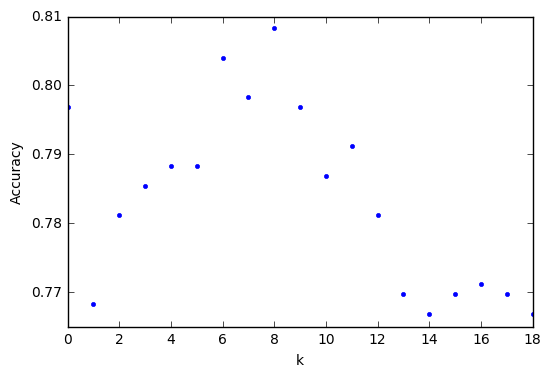

[0.79685264663805433, 0.76824034334763946, 0.7811158798283262, 0.78540772532188841, 0.78826895565092991, 0.78826895565092991, 0.80400572246065816, 0.79828326180257514, 0.80829756795422036, 0.79685264663805433, 0.7868383404864091, 0.79113018597997142, 0.7811158798283262, 0.76967095851216027, 0.76680972818311877, 0.76967095851216027, 0.77110157367668097, 0.76967095851216027, 0.76680972818311877]


In [33]:
acc = []

for i in range(1, 20):
    acc.append(cross(i))

plt.plot(acc,'.')
plt.xlabel('k')
_=plt.ylabel('Accuracy')
plt.show()
print acc

In [34]:
from sklearn import tree

x_train, x_test, y_train, y_test = train_test_split(alldata, label, test_size=0.30, random_state=1)
  
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

tree_predicted = clf.predict(x_test)
print clf.score(x_test, y_test)

0.576537911302


In [37]:
from sklearn import svm

numlabel = []

for i in range(len(label)):
    numlabel.append(ord(label[i]) - ord('A'))
    
print len(numlabel)

# svm
x_train, x_test, y_train, y_test = train_test_split(alldata, numlabel, test_size=0.30, random_state=1)

clf = svm.SVC(kernel = 'linear', decision_function_shape = 'ovr')
clf.fit(x_train, y_train)

y_pred_test = clf.predict(x_test)

print clf.score(x_test, y_test)

2328
0.809728183119


### if alldata 0.80
### resizedata_pca 0.70